In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px
from utils import  *
from scipy.signal import savgol_filter, find_peaks
import seaborn as sns
import plotly.express as px
import pickle

# Quick Analysis

<Axes: xlabel='timestamp'>

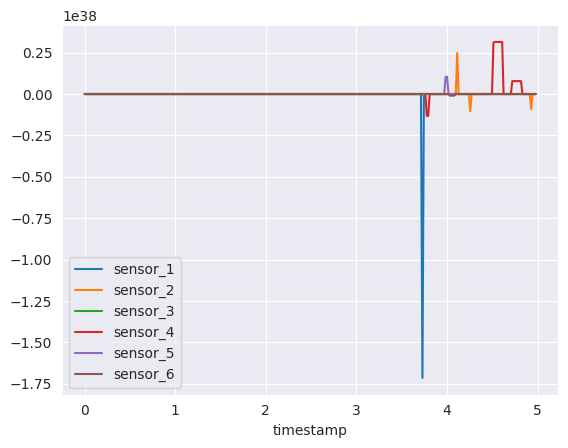

In [3]:
import numpy as np
import pandas as pd
df = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/experiments/optimizer_batbotV2_2D/data/230920/test_folding1/measurements/5_2(1.3867735625005218e+74).csv')
df.plot(x='timestamp')

In [ ]:
normalized_df = (df - df.min()) / (df.max() - df.min())

In [ ]:
px.line(df,x='timestamp',y=sensors_col)

# Compare 2 measurements with each other

In [ ]:
df_good = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/experiments/optimizer_batbotV2_2D/data/230916/test_folding2/measurements/19_9(0.15199679765090135).csv')

In [ ]:
df_bad = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/experiments/optimizer_batbotV2_5D/230919/test1/measurements/60_9(0.14567423108583852).csv')

In [ ]:
df_good['lift'] = df_good.sensor_4 + df_good.sensor_5 + df_good.sensor_6
df_bad['lift'] = df_bad.sensor_4 + df_bad.sensor_5 + df_bad.sensor_6

In [ ]:
plt.plot(df_good.timestamp, df_good.lift, label='good')
plt.plot(df_bad.timestamp, df_bad.lift, label='bad')
plt.legend()
plt.show()

In [ ]:
df_good.mean(),df_bad.mean()

In [ ]:
df_bad.mean()

In [ ]:
for sensor in sensors_col:
    plt.plot(df_bad.timestamp, df_bad[sensor], label='bad')
    plt.hlines(df_bad[sensor].mean(),0,5,label='bad mean', colors='r')
    plt.plot(df_good.timestamp, df_good[sensor], label='good')
    plt.hlines(df_good[sensor].mean(),0,5,label='good mean', colors='g')
    plt.legend()
    plt.title(sensor)
    plt.show()


In [ ]:
def fitness_batbotV1(measurements, plot=False, smooth=False):
    """
    Calculates fitness score of solution from the measured data
    :param measurements: np.aray of data provided by read_measurements_df()
    :param smooth: Boolean station if smoothing using savgol_filter is applied.
    :return: score
    """
    measurements = measurements.copy()
    if smooth:
        y = measurements[sensors_col]
        measurements[sensors_col] = savgol_filter(y, 10, 3, axis=0)
    if plot:
        measurements.plot(x='timestamp')
        plt.show()
    return (measurements.drop('timestamp', axis=1).mean()**2).sum()

In [ ]:
def fitness_project(measurements):
    """
    Calculates the fitness of a measurement slicing it from the back to learn the influence of the tail values and fits
     a linear function to project the real fitness were the tail values are no influence
    :param measurements: np.aray of data provided by read_measurements_df()
    :return: score
    """
    scores_avg = []
    for i in range(1, 200):  # for a 5 seconds test we obtain 320 data, doing the analysis with the las 200 showed to
        # the most stable
        scores_avg.append(fitness_batbotV1(measurements[:-i], smooth=True))
    x = np.arange(len(scores_avg))
    fit = np.poly1d(np.polyfit(x, scores_avg, 1))
    return fit(0), scores_avg

In [ ]:
_, scores = fitness_project(df_good)

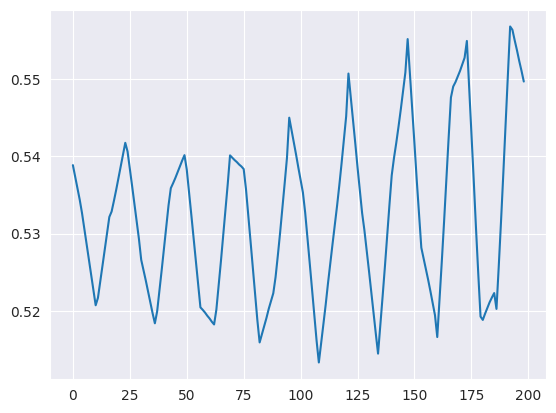

In [16]:
plt.plot(scores)

In [ ]:
for sensor in sensors_col:
    plt.plot(df_good.timestamp, df_good[sensor], label = 'good')
    #plt.plot(df_bad.timestamp, df_bad[sensor], label = 'bad')
    plt.legend()
    plt.show()

In [ ]:
def fitness_max_min_avg(measurements):
    """
    Calculates fitness score of solution from the measured data
    :param measurements: np.aray of data provided by read_measurements_df()
    :return: score
    """
    sensor_avg = []
    for sensor in sensor_col:
        peaks, _ = find_peaks(measurements[sensor])
        valleys, _ = find_peaks(-measurements[sensor])
        max = measurements[sensor][peaks].mean()
        min = measurements[sensor][valleys].mean()
        sensor_avg.append((max+min)/2)
    return abs(np.array(sensor_avg).sum())

def fitness_max_min(measurements):
    """
    Calculates fitness score of solution from the measured data
    :param measurements: np.aray of data provided by read_measurements_df()
    :return: score
    """
    return abs(((measurements.drop('timestamp', axis=1).max()+measurements.drop('timestamp', axis=1).min())/2).sum())

def finess_project(measurements):
    scores_avg = []
    for i in range(1,200):
        scores_avg.append(fitness_batbotV1(measurements[:-i], smooth=True))
    x = np.arange(len(scores_avg))
    fit = np.poly1d(np.polyfit(x, scores_avg,1))
    return fit(0)


In [ ]:
# assign directory
directory = 'data/230706(2)'
for i, filename in enumerate(os.listdir(directory)):
    if filename[-1] == 'v':
        f = os.path.join(directory, filename)
        df = pd.read_csv(f)
        print(i, df.shape)
        y = df[[f'sensor_{i}' for i in range(1,7)]]
        df[[f'sensor_{i}' for i in range(1,7)]] = savgol_filter(y, 10, 3, axis=0)
        scores_avg = []
        scores_max_min = []
        scores_max_min_avg = []
        for i in range(1,200):
            scores_avg.append(fitness_batbotV1(df[:-i]))
            scores_max_min.append(fitness_max_min(df[:-i]))
            scores_max_min_avg.append(fitness_max_min_avg(df[:-i]))
        x = np.arange(len(scores_avg))
        fit = np.poly1d(np.polyfit(x, scores_avg,1))
        y = fit(x)

        plt.plot(scores_avg, label='avg')
        plt.plot(y, label=fit(0))
        plt.plot(scores_max_min, label='max_min')
        plt.plot(scores_max_min_avg, label='max_min_avg')
        plt.title(filename)
        plt.legend()
        plt.show()
from scipy.signal import find_peaks
peaks, _ = find_peaks(df.sensor_1)
plt.plot(df.timestamp,df.sensor_1)
plt.scatter(df.timestamp[peaks],df.sensor_1[peaks])
df = pd.read_csv("data/230706(1)/1_2_[0.22775696 0.45077319 0.74891196]_0.5779445842122174.csv")
y = df[[f'sensor_{i}' for i in range(1,7)]]
df[[f'sensor_{i}' for i in range(1,7)]] = savgol_filter(y, 10, 3, axis=0)
df.plot(x='timestamp')
# assign directory
directory = 'data'

sensor_col=[f'sensor_{i}' for i in range(1,7)]
#b = pd.read_csv('../../analysis/sensor_calibration.csv')
#shift = pd.Series(data=b['data'].to_list(), index=b['index'].to_list())
#shift['timestamp'] = 0.0
# that directory
for i, filename in enumerate(os.listdir(directory)):
    if filename[:3] == '0_0' or filename[:3] == '1_2':
        f = os.path.join(directory, filename)
        df = pd.read_csv(f)
        #df = df - shift
        #fig = px.line(df, x='timestamp', y = sensor_col, title=f"score: {abs(df.drop('timestamp', axis=1).mean().sum())}")
        #fig.show()
        df['timestamp'] = df['timestamp'] - df['timestamp'][0]
df.plot(x='timestamp',title=filename)

# Pickles to df


In [ ]:
file = open(f, 'rb')
solutions = pickle.load(file)
file.close()

In [ ]:
# assign directory
df_dict_list = []
directory = 'data/230710/'
gen = 0
for i, filename in enumerate(os.listdir(directory)):
    if filename[-3:] == 'kle':
        f = os.path.join(directory, filename)

        file = open(f, 'rb')
        solutions = pickle.load(file)['solutions']
        file.close()

        for i, sol in enumerate(solutions):
            df_dict_list.append({'Generation': gen,
                             'Id': i,
                             'Score': sol[1],
                             'Motor': sol[0][0],
                             'Neutral': sol[0][1],
                             'Amplitude': sol[0][2]})
        gen += 1

df3 = pd.DataFrame(df_dict_list)


In [ ]:
df2['Generation'] = df2['Generation'] + df1['Generation'].iloc[-1] + 1
df3['Generation'] = df3['Generation']+ df2['Generation'].iloc[-1] + 1
df = pd.concat([df1, df2, df3])

In [ ]:
results = pd.read_csv('data/230710/0_0.csv')
results['test'] = 0
for i in range(1,10):
    df = pd.read_csv(f'data/230710/0_{i}.csv')
    df['test'] = i
    results = pd.concat([results, df])

In [ ]:
measurements = results.copy()
for test in range(10):
    scores_avg = []
    for i in range(1, 200):  # for a 5 seconds test we obtain 320 data, doing the analysis with the las 200 showed to
        # the most stable
        scores_avg.append(fitness_batbotV1(measurements[measurements.test == test][:-i].drop('test', axis=1), smooth=True))
    x = np.arange(len(scores_avg))
    fit = np.poly1d(np.polyfit(x, scores_avg, 1))
    plt.plot(scores_avg)
    plt.plot(x,fit(x))
#plt.legend()
plt.show()

In [ ]:
plt.plot(scores_avg)
plt.plot(x,fit(x))
plt.show()